In [32]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from feature_engine.datetime import DatetimeFeatures
import joblib
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [5]:
train_df=pd.read_csv("data/train.csv")
val_df=pd.read_csv("data/val.csv")
test_df=pd.read_csv("data/test.csv")

### Split the Data

In [6]:
def split_data(data):
	X = data.drop(columns="price")
	y = data.price.copy()
	return (X, y)

In [7]:
X_train, y_train = split_data(train_df)

In [8]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Indigo,2019-05-21,Kolkata,Banglore,17:15:00,19:50:00,155,0.0,No Info
1,Indigo,2019-05-09,Delhi,Cochin,23:30:00,04:35:00,305,1.0,No Info
2,Indigo,2019-03-03,Chennai,Kolkata,05:15:00,07:35:00,140,0.0,No Info
3,Jet Airways,2019-05-12,Kolkata,Banglore,06:30:00,04:40:00,1330,1.0,In-flight meal not included
4,Indigo,2019-05-15,Banglore,Delhi,18:55:00,21:50:00,175,0.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-06-01,Delhi,Cochin,19:45:00,04:25:00,520,1.0,No Info
636,Indigo,2019-03-24,Kolkata,Banglore,15:10:00,20:15:00,305,1.0,No Info
637,Indigo,2019-05-18,Delhi,Cochin,04:55:00,21:00:00,965,1.0,No Info
638,Jet Airways,2019-06-27,Delhi,Cochin,20:55:00,19:00:00,1325,1.0,In-flight meal not included


In [9]:
y_train

0       4804
1       8177
2       6482
3       8586
4       4823
       ...  
635    14714
636     6762
637     6758
638    10262
639    13941
Name: price, Length: 640, dtype: int64

In [10]:
X_val, y_val = split_data(val_df)

print(X_val.shape, y_val.shape)

(160, 9) (160,)


In [11]:
X_test, y_test = split_data(test_df)

print(X_test.shape, y_test.shape)

(200, 9) (200,)


### Meta-info

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


 ###   Data Preprocessing

In [13]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [14]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [20]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [21]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [22]:
preprocessor.fit_transform(X_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_Business class,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.026489,-1.330535,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.250014,0.501300,-0.972889,0.845280,0.733455,-0.519074,0.860713,1.533727
1,-0.736012,0.158175,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.250014,0.098751,0.035449,-0.568121,1.767401,0.297160,-1.320608,0.608285
2,-1.055537,-1.330535,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.537795,-1.913999,1.547957,-1.274821,-1.334436,-0.519074,-0.884344,0.608285
3,1.248916,0.158175,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.250014,0.098751,1.547957,-0.214771,-1.162112,0.297160,-1.320608,0.916766
4,-0.987759,-1.330535,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.250014,0.300025,-0.468720,0.138579,0.905779,1.657550,1.151556,1.533727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.319661,0.158175,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.143918,0.702575,1.043788,-1.510387,1.078104,1.113394,-1.320608,-0.008676
636,-0.736012,0.158175,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.537795,-1.310174,1.547957,1.198630,0.388807,-0.791152,1.006135,-0.625637
637,0.542088,0.158175,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.250014,0.300025,1.043788,0.491930,-1.506760,1.657550,1.151556,-1.551079
638,1.239234,0.158175,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.143918,1.507675,0.035449,1.551980,1.250428,1.657550,0.860713,-1.551079


In [23]:
preprocessor.fit_transform(X_train).shape

(640, 34)

### Model Selection

In [25]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [26]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [27]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [33]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)
    
	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

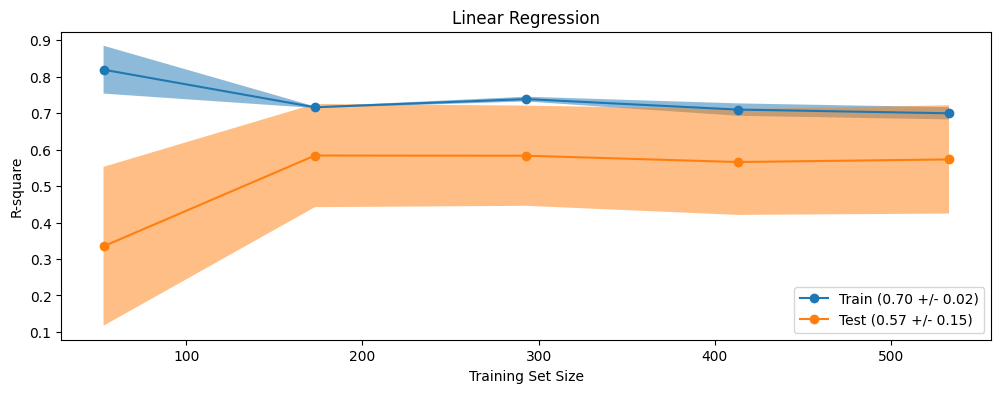

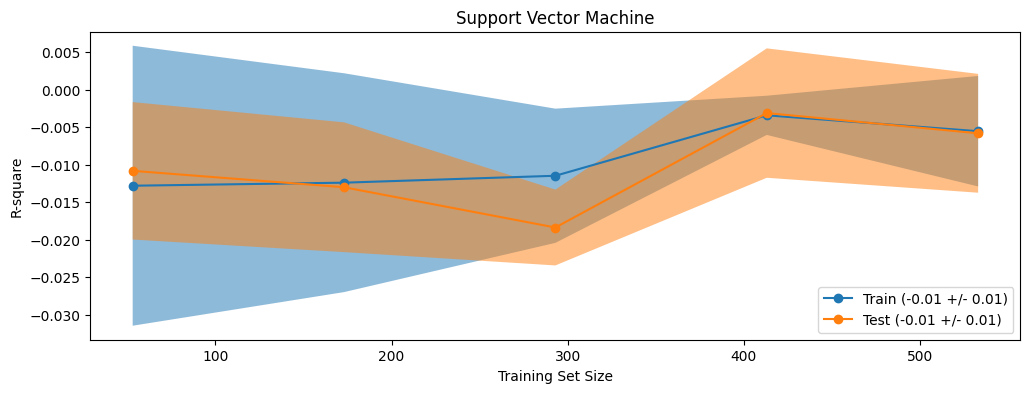

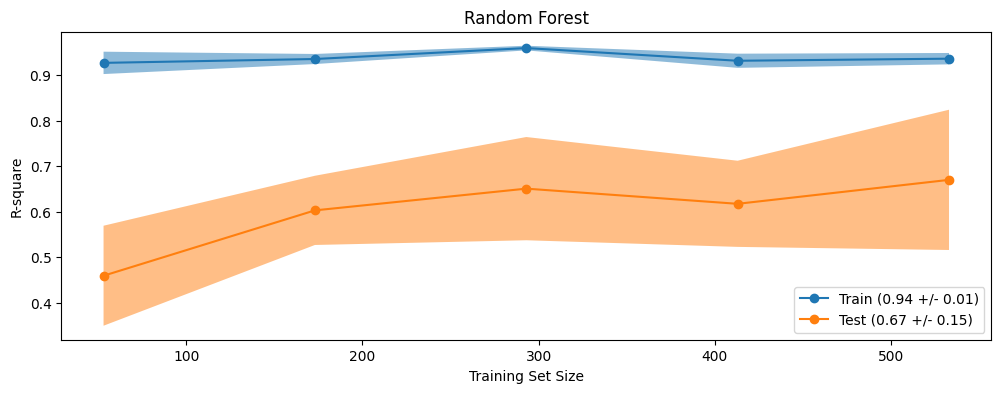

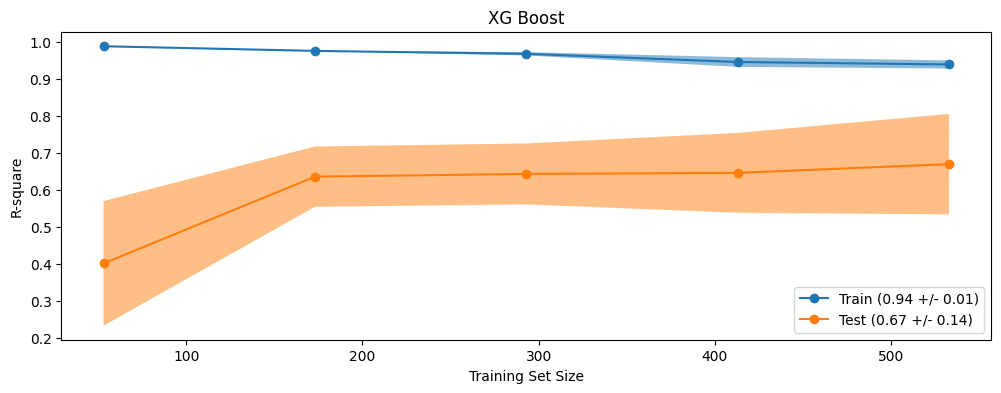

In [34]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

In [35]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [36]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

 ### Model Evaluation

In [37]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [38]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")


R2 score on Training data is = 0.9470370958028789


In [39]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")


R2 score on Test data is = 0.7557748127746661


### Model Persistence

In [50]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [51]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [52]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.7557748127746661